## Import Libraries

In [ ]:
!pip install praw

     |████████████████████████████████| 163kB 2.9MB/s 
     |████████████████████████████████| 71kB 7.7MB/s 


In [ ]:
!pip install yahoofinancials

  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-cp37-none-any.whl size=15192 sha256=dc52be39ba80a8fe19b9b974fb135ba33fed3834b428469afc42552be6fcb196
  Stored in directory: /root/.cache/pip/wheels/d9/7e/cf/4977a8572d5247242a4b13018d1d36923024ba84236e0d28bc
Successfully built yahoofinancials


In [ ]:
import pandas_datareader.data as reader
import datetime as dt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

import urllib, json
import praw
from yahoofinancials import YahooFinancials

import tensorflow as tf
import re
import string

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow import keras

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import time
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import tensorflow_datasets as tfds

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Retrieve Reddit Comments

In [ ]:
def get_reddit(ticker, date_after, date_before):
  after = (dt.datetime.now() - date_after).days
  before = (dt.datetime.now() - date_before).days
  url = f"https://api.pushshift.io/reddit/search/comment/?q={ticker.lower()}&subreddit=wallstreetbets&before={before}d&after={after}d&size=500"
  response = urllib.request.urlopen(url)
  de = json.loads(response.read())
  df = prepare_reddit(de['data'])
  
  return df

In [ ]:
def prepare_reddit(l):
  topics_dict = {"score":[], 
        "id":[], 
        #"url":[],
        "created": [],
        "body":[]}
  for d in l:
    topics_dict["score"].append(d['score'])
    topics_dict["id"].append(d['id'])
    #topics_dict["url"].append(d['permalink'])
    topics_dict["created"].append(d['author'])
    topics_dict["body"].append(d['body'])
  return pd.DataFrame(topics_dict)

In [ ]:
get_reddit('pltr', dt.datetime(2021,5,10), dt.datetime(2021,5,17))

,score,id,created,body
0,7,gxll1ex,RPMayhem,lol RKT and PLTR in retrograde
1,2,gxllj5g,sweet_as_stevia,PLTR should rename its ticker to OOF cuz it hu...
2,2,gxllt0g,HighlyUniqueName,Now do PLTR
3,5,gxllz67,Juuliantjis,"Buying penn, pltr, ag and double dowm on urani..."
4,1,gxlm21m,sweet_as_stevia,"At the PLTR drive through _Ma’am, Extra dip on..."
...,...,...,...,...
95,3,gxluk41,Larissa_MW,PLTR is a bag holder factory
96,10,gxluk71,DTello13,"Man, there is no stock i hate more than PLTR"
97,3,gxluk8y,Pltr_x2-4_Tsla,"Pltr needs to go up at least 30%, on top that ..."
98,6,gxlukrk,YoungJebediah,PLTR partying like it's November 2020


In [ ]:
def get_reddits_body(ticker, date):
  text = ''
  until = date
  since = date - dt.timedelta(days = 7)
  print(since, until)
  df = get_reddit(ticker, since, until)
  for content in df["body"]:
    text += content
    text += " " #######
  return text

In [ ]:
get_reddits_body("pltr", dt.datetime(2021,5,17))

2021-05-10 00:00:00 2021-05-17 00:00:00


"lol RKT and PLTR in retrograde PLTR should rename its ticker to OOF cuz it hurts to carry Now do PLTR Buying penn, pltr, ag and double dowm on uranium.\nToday At the PLTR drive through _Ma’am, Extra dip on the side?_ Come, make you bets! \n\nWill PLTR have 10 Red days in a row?\n\nIs there even any stock on earth which behaves so ridiculously (10 red days in a row) on no news? Must be a new record... I think. I think. Maybe ummmmm I think I'm gonna try and buy PLTR again. If PLTR drops that low I will buy all that I can afford PLTR to $20 pls I’m holding for long term, by long term I mean at least 5 years. You still see a lot of good news for PLTR, meaning there’s still more room for the price to go down, we will only the see the bottom when there’extreme negative sentiment about the stock, now there isn’t yet. Cant believe im still bag holding pltr PLTR U Fubo LMND OPEN puts are free money I don’t hold PLTR stock, I do have some calls a few months out, but really hoping for a nice re

## Make Dataset

In [ ]:
# returns
def Re(df):
  return df.resample('7D').last().pct_change().apply(lambda x: np.log(1+x))

# volatility
def Vo(df):
  de = df.pct_change().apply(lambda x: np.log(1+x))
  vo = de.rolling(window = 7).std()*np.sqrt(7)
  ts = vo.resample('7D').last()
  ts = ts[0:(len(ts)-1)]

  return ts

In [ ]:
# don't input date on weekend for retrieving volatility
# HERE WE REQUIRE BEGIN date to be on Sunday
def test_data(ticker, begin, end):
  data = {'Date':[], 'Reddits':[]}
  date = begin + dt.timedelta(days = 1)
  while(date + dt.timedelta(days = 7) < end):
    s = get_reddits_body(ticker, date + dt.timedelta(days = 7))
    time.sleep(1)
    data['Reddits'].append(s)
    data['Date'].append(date)
    date += dt.timedelta(days = 7)
  df = pd.DataFrame(data)
  de = reader.get_data_yahoo(ticker,begin,end)['Adj Close']
  vo = Vo(de).reset_index()[['Adj Close']]#.dropna()
  re = Re(de).reset_index()
  df = pd.concat([df,vo], axis = 1)
  df = df.rename(columns = {'Adj Close':'Volatility'})
  
  return df.dropna()

In [ ]:
Vo(reader.get_data_yahoo("tsla",dt.datetime(2017,1,9), dt.datetime(2017,5,12))['Adj Close'])

Date
2017-01-09         NaN
2017-01-16    0.040403
2017-01-23    0.031960
2017-01-30    0.020310
2017-02-06    0.032566
2017-02-13    0.067832
2017-02-20    0.080328
2017-02-27    0.079985
2017-03-06    0.014378
2017-03-13    0.055069
2017-03-20    0.066153
2017-03-27    0.039843
2017-04-03    0.078688
2017-04-10    0.071936
2017-04-17    0.055938
2017-04-24    0.033521
2017-05-01    0.085832
Freq: 7D, Name: Adj Close, dtype: float64

In [ ]:
data = {'Date':[]}
date = dt.datetime(2017,1,8) + dt.timedelta(days = 1)
while(date + dt.timedelta(days = 7) < dt.datetime(2017,5,12)):
    data['Date'].append(date)
    date += dt.timedelta(days = 7)

data

{'Date': [datetime.datetime(2017, 1, 9, 0, 0),
  datetime.datetime(2017, 1, 16, 0, 0),
  datetime.datetime(2017, 1, 23, 0, 0),
  datetime.datetime(2017, 1, 30, 0, 0),
  datetime.datetime(2017, 2, 6, 0, 0),
  datetime.datetime(2017, 2, 13, 0, 0),
  datetime.datetime(2017, 2, 20, 0, 0),
  datetime.datetime(2017, 2, 27, 0, 0),
  datetime.datetime(2017, 3, 6, 0, 0),
  datetime.datetime(2017, 3, 13, 0, 0),
  datetime.datetime(2017, 3, 20, 0, 0),
  datetime.datetime(2017, 3, 27, 0, 0),
  datetime.datetime(2017, 4, 3, 0, 0),
  datetime.datetime(2017, 4, 10, 0, 0),
  datetime.datetime(2017, 4, 17, 0, 0),
  datetime.datetime(2017, 4, 24, 0, 0),
  datetime.datetime(2017, 5, 1, 0, 0)]}

In [ ]:
pd.concat([pd.DataFrame(data), Vo(reader.get_data_yahoo("tsla",dt.datetime(2017,1,9), dt.datetime(2017,5,12))['Adj Close']).reset_index()[['Adj Close']]], axis = 1)

,Date,Adj Close
0,2017-01-09,NaN
1,2017-01-16,0.040403
2,2017-01-23,0.031960
3,2017-01-30,0.020310
4,2017-02-06,0.032566
5,2017-02-13,0.067832
6,2017-02-20,0.080328
7,2017-02-27,0.079985
8,2017-03-06,0.014378
9,2017-03-13,0.055069


In [ ]:
df = test_data('tsla',dt.datetime(2017,1,8),dt.datetime(2021,5,12))

2017-01-09 00:00:00 2017-01-16 00:00:00
2017-01-16 00:00:00 2017-01-23 00:00:00
2017-01-23 00:00:00 2017-01-30 00:00:00
2017-01-30 00:00:00 2017-02-06 00:00:00
2017-02-06 00:00:00 2017-02-13 00:00:00
2017-02-13 00:00:00 2017-02-20 00:00:00
2017-02-20 00:00:00 2017-02-27 00:00:00
2017-02-27 00:00:00 2017-03-06 00:00:00
2017-03-06 00:00:00 2017-03-13 00:00:00
2017-03-13 00:00:00 2017-03-20 00:00:00
2017-03-20 00:00:00 2017-03-27 00:00:00
2017-03-27 00:00:00 2017-04-03 00:00:00
2017-04-03 00:00:00 2017-04-10 00:00:00
2017-04-10 00:00:00 2017-04-17 00:00:00
2017-04-17 00:00:00 2017-04-24 00:00:00
2017-04-24 00:00:00 2017-05-01 00:00:00
2017-05-01 00:00:00 2017-05-08 00:00:00
2017-05-08 00:00:00 2017-05-15 00:00:00
2017-05-15 00:00:00 2017-05-22 00:00:00
2017-05-22 00:00:00 2017-05-29 00:00:00
2017-05-29 00:00:00 2017-06-05 00:00:00
2017-06-05 00:00:00 2017-06-12 00:00:00
2017-06-12 00:00:00 2017-06-19 00:00:00
2017-06-19 00:00:00 2017-06-26 00:00:00
2017-06-26 00:00:00 2017-07-03 00:00:00


In [ ]:
df

,Date,Reddits,Volatility
1,2017-01-16,"AMZN, TSLA, TSLA, AMZN More like AMZN, NVDA, T...",0.040403
2,2017-01-23,They just wont a lawsuit:\n\nhttp://www.profit...,0.031960
3,2017-01-30,Tesla ($TSLA) is not associated with the Trans...,0.020310
4,2017-02-06,You won't believe but TSLA remains extremely s...,0.032566
5,2017-02-13,The thing is that people always love the first...,0.067832
...,...,...,...
221,2021-04-05,I bought the TSLA dip and it dipped lower. Now...,0.078118
222,2021-04-12,Exactly. But when Tesla does something they sa...,0.101964
223,2021-04-19,correct holding some of this two contract posi...,0.066478
224,2021-04-26,"AAPL, AMD, AMZN, FB, SHOP, TSLA will crush ear...",0.085849


## Tensorflow Dataset

In [ ]:
def remove_stopwords(df_pd, colname, stopwords_list):
    '''
    The function looks at the column df_pd[colname] in the input dataframe df_pd,
    and first change all characters to lowercase, 
    split texts into a list of word chunks according to empty space,
    and then reconcatenate the word chunks that are not in the list of stopwords stopwords_list
    into a string of texts again.

    Limitation: this function does not deal with stopwords right before punctuation marks.
    '''
    all_words_in_list = df_pd[colname].str.lower().str.split()
    stopwords_removed = all_words_in_list.apply(lambda x: ' '.join([word for word in x if word not in stopwords_list]))

    return stopwords_removed

In [ ]:
def make_tensorflow_dataset(df):

    df_copy = df

    stopwords_list = stopwords.words("english")  # a list of stopwords in english
    df_copy["Reddits"] = remove_stopwords(df_copy, "Reddits", stopwords_list)

  # Step 2: prepare the tensorflow dataset
    data = tf.data.Dataset.from_tensor_slices(
        (
            {"Reddits" : df_copy[["Reddits"]]}, 
            {"Volatility" : df_copy[["Volatility"]]}
        )
    )

    return data

In [ ]:
df_ts = make_tensorflow_dataset(df)

In [ ]:
df_ts

<TensorSliceDataset shapes: ({Reddits: (1,)}, {Volatility: (1,)}), types: ({Reddits: tf.string}, {Volatility: tf.float64})>

## Tensorflow Model

In [ ]:
# split data
# set seed to ensure the same random shuffling every time
import random
random.seed(1205)
df_ts = df_ts.shuffle(buffer_size = len(df_ts))

In [ ]:
train_size = int(0.7*len(df_ts))
val_size   = int(0.1*len(df_ts))

train = df_ts.take(train_size)
val   = df_ts.skip(train_size).take(val_size)
test  = df_ts.skip(train_size + val_size)

In [ ]:
len(train), len(val), len(test)

(157, 22, 46)

In [ ]:
def standardization(input_data):
    lowercase = tf.strings.lower(input_data) #lowercase 
    no_punctuation = tf.strings.regex_replace(lowercase, #remove punctuations
                                  '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation

In [ ]:
size_vocab = 2000

vectorize_layer = TextVectorization(
    standardize = standardization,
    max_tokens = size_vocab, # only consider this many words
    output_mode = 'int',
    output_sequence_length = 500) 

vectorize_layer.adapt(train.map(lambda x, y: x['Reddits']))

In [ ]:
reddits_input = keras.Input(
    shape = (1,),
    name = "Reddits",
    dtype = "string"
)

In [ ]:
reddits_input

<KerasTensor: shape=(None, 1) dtype=string (created by layer 'Reddits')>

In [ ]:
# vectorize title texts into tensor containing data
reddits_features = vectorize_layer(reddits_input)
# Turns positive integers (indexes) into dense vectors of fixed size
reddits_features = layers.Embedding(input_dim = size_vocab, output_dim = 10, name = "embedding")(reddits_features)
# Applies Dropout to the input to avoid overfitting
reddits_features = layers.Dropout(rate = 0.2, name = "dropout_1")(reddits_features)
# pooling To reduce variance, reduce computation complexity
reddits_features = layers.GlobalAveragePooling1D(name = "pooling")(reddits_features)
# Applies Dropout to the input to avoid overfitting
reddits_features = layers.Dropout(rate = 0.2, name = "dropout_2")(reddits_features)
# add a dense layer
reddits_features = layers.Dense(32, activation = "relu", name = "dense")(reddits_features)
# generate output
reddits_output = layers.Dense(1, name = "Volatility")(reddits_features)

In [ ]:
model_reddits = keras.Model(
    inputs = reddits_input,
    outputs = reddits_output
)

In [ ]:
model_reddits.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Reddits (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 500)               0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 10)           20000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 10)           0         
_________________________________________________________________
pooling (GlobalAveragePoolin (None, 10)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                352 

In [ ]:
model_reddits.compile(optimizer = "adam",
                      loss = losses.MeanSquaredError(),
                      metrics = keras.metrics.MeanSquaredError())

In [ ]:
history_reddits = model_reddits.fit(train, 
                                    validation_data = val,
                                    epochs = 25)

Epoch 1/25
157/157 [==============================] - 1s 4ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 2/25
157/157 [==============================] - 0s 2ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 3/25
157/157 [==============================] - 0s 2ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 5.5876e-04 - val_mean_squared_error: 5.5876e-04
Epoch 4/25
157/157 [==============================] - 0s 2ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 5/25
157/157 [==============================] - 0s 2ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 6/25
157/157 [==============================] - 0s 2ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 7/25
157/157 [

In [ ]:
# history_reddits.history

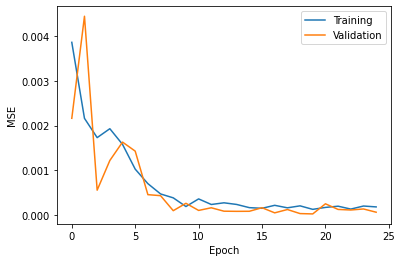

In [ ]:
plt.plot(history_reddits.history["mean_squared_error"], label = "Training")
plt.plot(history_reddits.history["val_mean_squared_error"], label = "Validation")
plt.gca().set(xlabel = "Epoch", ylabel = "MSE")
plt.legend()

## Model Prediction

In [ ]:
model_reddits.evaluate(test)

46/46 [==============================] - 0s 2ms/step - loss: 1.1677e-04 - mean_squared_error: 1.1677e-04


[0.00011677153088385239, 0.00011677153088385239]

In [ ]:
test_volatility_pred = model_reddits.predict(test).reshape(-1)
test_volatility_pred

array([0.06589069, 0.06284197, 0.07081769, 0.06087088, 0.20067663,
       0.06870934, 0.04326063, 0.08159654, 0.0739132 , 0.13526464,
       0.09076866, 0.06582532, 0.07915878, 0.04691627, 0.07121079,
       0.08214187, 0.06843946, 0.11295553, 0.08404192, 0.0577556 ,
       0.05630063, 0.05926352, 0.05822406, 0.06939037, 0.07507297,
       0.05335908, 0.10933588, 0.10620118, 0.05087569, 0.04117827,
       0.09865897, 0.06004047, 0.04421229, 0.10938719, 0.04998215,
       0.07224309, 0.05204478, 0.11802246, 0.15147814, 0.18815605,
       0.31238365, 0.04759483, 0.04007282, 0.07710232, 0.05106296,
       0.03897595], dtype=float32)

In [ ]:
test_vol_true = tfds.as_numpy(test.map(lambda x, y: y["Volatility"]))

test_volatility_true = []
for i in test_vol_true:
    test_volatility_true.append(i[0])

test_volatility_true

[0.0575725755794812,
 0.04893955321461019,
 0.07234243335907468,
 0.07647431558890834,
 0.09097365812957676,
 0.16480357517472177,
 0.0664778237182052,
 0.18328833909000428,
 0.051835039377475724,
 0.059418660901134845,
 0.12565185014723415,
 0.07547070858115412,
 0.11668654979547285,
 0.15659740816536363,
 0.05792749877635626,
 0.10435530540858459,
 0.08637126107924062,
 0.0995507194273067,
 0.05784155783597818,
 0.038121956161097814,
 0.11855215588730793,
 0.0203102357026187,
 0.09316864264608495,
 0.1542278726311534,
 0.15554019856927573,
 0.05784921591046433,
 0.03889389344495769,
 0.07664675780186359,
 0.0639751726806966,
 0.050447101393345704,
 0.031960211094904135,
 0.05557659632506384,
 0.042389547776585566,
 0.036521386390042904,
 0.05230609733621018,
 0.03788538030450558,
 0.13259614476306916,
 0.0585280240058891,
 0.08160604139337893,
 0.032566354404926466,
 0.027691206507768195,
 0.0803282249313422,
 0.28939132676339097,
 0.03303572671266322,
 0.03851719185978172,
 0.055544

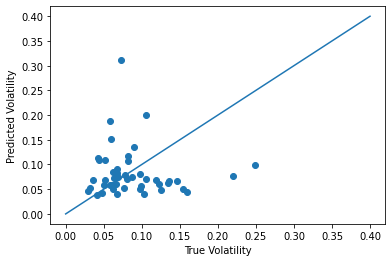

In [ ]:
plt.scatter(test_volatility_true, test_volatility_pred)
plt.xlabel("True Volatility")
plt.ylabel("Predicted Volatility")
plt.plot([0, 0.4], [0, 0.4])

In [ ]:
model_reddits.evaluate(df_ts)

225/225 [==============================] - 0s 1ms/step - loss: 7.3765e-05 - mean_squared_error: 7.3765e-05


[7.376473513431847e-05, 7.376473513431847e-05]

In [ ]:
all_volatility_pred = model_reddits.predict(df_ts).reshape(-1)
all_volatility_pred

array([0.06054502, 0.09219582, 0.10938995, 0.05307597, 0.04580277,
       0.06589069, 0.07953504, 0.08220615, 0.0709583 , 0.04336268,
       0.04970952, 0.1038733 , 0.10812418, 0.07400526, 0.08298586,
       0.12368397, 0.09424253, 0.16935933, 0.06033683, 0.0564238 ,
       0.05504588, 0.06741923, 0.15679818, 0.12992452, 0.06582532,
       0.25480625, 0.09558153, 0.14540109, 0.05335908, 0.09076866,
       0.19346836, 0.10893638, 0.09799669, 0.09865897, 0.13807902,
       0.15414797, 0.0512735 , 0.06648843, 0.13518645, 0.07577242,
       0.03828635, 0.07081769, 0.04107381, 0.04998215, 0.06284197,
       0.04847187, 0.11295553, 0.11163668, 0.14813703, 0.06069572,
       0.07800719, 0.0901732 , 0.04114832, 0.07352588, 0.04117827,
       0.0487892 , 0.09985887, 0.1747503 , 0.04408579, 0.06042618,
       0.05087569, 0.07148017, 0.1102769 , 0.15942171, 0.03897595,
       0.06671795, 0.07199414, 0.09840625, 0.07105469, 0.08261384,
       0.05626098, 0.16276444, 0.06870934, 0.10938719, 0.05503

In [ ]:
all_vol_true = tfds.as_numpy(df_ts.map(lambda x, y: y["Volatility"]))

all_volatility_true = []
for i in all_vol_true:
    all_volatility_true.append(i[0])

all_volatility_true

[0.014377792486590484,
 0.050447101393345704,
 0.07782838770558449,
 0.09583296539489856,
 0.18671923499820445,
 0.13763277184636574,
 0.04407190089317895,
 0.12565185014723415,
 0.0506122752552525,
 0.07547070858115412,
 0.08805196573920954,
 0.027691206507768195,
 0.04783636264958061,
 0.0540450819123836,
 0.09755975947215612,
 0.055937552579905056,
 0.043931680691633224,
 0.07911631270750143,
 0.06356068070312669,
 0.1906378424929663,
 0.0203102357026187,
 0.04040332138855422,
 0.06689583113781834,
 0.08106498455209356,
 0.14180130597368593,
 0.07811762367194151,
 0.05335732561739296,
 0.0585280240058891,
 0.0787147415723861,
 0.22004791728255452,
 0.04442307575760854,
 0.02437294847840595,
 0.316855528199812,
 0.0633217841936875,
 0.11063320202690755,
 0.15659740816536363,
 0.1542278726311534,
 0.33482350916997394,
 0.03721935150235067,
 0.03346791514774061,
 0.13259614476306916,
 0.07789180146775425,
 0.13447326264820827,
 0.08660731636028188,
 0.032140368102106666,
 0.10435530540

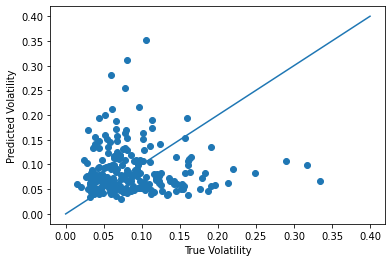

In [ ]:
plt.scatter(all_volatility_true, all_volatility_pred)
plt.xlabel("True Volatility")
plt.ylabel("Predicted Volatility")
plt.plot([0, 0.4], [0, 0.4])

# -----------------------------------------------------------------------------------------------------------------

# Sentiment [Emotion Labels]


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

In [ ]:
from nltk import word_tokenize
from nltk.corpus import stopwords
import string

In [ ]:
import nltk
from nltk.stem import *
from nltk.corpus import sentiwordnet as swn

In [ ]:
stop_and_punc = set(stopwords.words('english') + list(string.punctuation))

In [ ]:
eg = "This is an example sentence. We are going to use this to test our list comprehension?"
[i for i in word_tokenize(eg.lower()) if i not in stop_and_punc]

['example', 'sentence', 'going', 'use', 'test', 'list', 'comprehension']

In [ ]:
nltk.pos_tag([i for i in word_tokenize(eg.lower()) if i not in stop_and_punc])

[('example', 'NN'),
 ('sentence', 'NN'),
 ('going', 'VBG'),
 ('use', 'JJ'),
 ('test', 'NN'),
 ('list', 'NN'),
 ('comprehension', 'NN')]

In [ ]:
nltk.pos_tag(word_tokenize(eg.lower()))

In [ ]:
def cleanTokenizeTagText(textString):
    # stop_and_punc = set(stopwords.words('english') + list(string.punctuation))
    punc = list(string.punctuation)
    result = [i for i in word_tokenize(textString.lower()) if i not in punc]
    result = nltk.pos_tag(result)

    return result

In [ ]:
cleanTokenizeTagText(eg)

In [ ]:
# try with senti synsets
list(swn.senti_synsets("beautiful"))

[SentiSynset('beautiful.a.01'), SentiSynset('beautiful.s.02')]

In [ ]:
print(list(swn.senti_synsets("fat","n"))[0].pos_score())
print(list(swn.senti_synsets("fat","a"))[0].pos_score())

0.0
0.125


In [ ]:
for a, b in [('NN', 'n'), ('VB', 'v'), ('JJ', 'a'), ('RB', 'r')]:
    print(a, b)

NN n
VB v
JJ a
RB r


In [ ]:
def CalculateScore(textString):
    
    wordList = cleanTokenizeTagText(textString)
    num_words = len(wordList)

    posScore = 0
    negScore = 0
    correspond = [('NN', 'n'), ('VB', 'v'), ('JJ', 'a'), ('RB', 'r')]

    for word_tag in wordList:
        for tag, sentiTag in correspond:
            if tag in word_tag[1] and len(list(swn.senti_synsets(word_tag[0], sentiTag))) > 0:
                posScore += (list(swn.senti_synsets(word_tag[0], sentiTag))[0]).pos_score()
                negScore += (list(swn.senti_synsets(word_tag[0], sentiTag))[0]).neg_score()

    return (posScore, negScore)

In [ ]:
dfScores = df.Reddits.apply(CalculateScore)
df["PosScore"] = [tup[0] for tup in dfScores]
df["NegScore"] = [tup[1] for tup in dfScores]

In [ ]:
df

,Date,Reddits,Volatility,PosScore,NegScore
1,2017-01-16,"More like AMZN, NVDA, TSLA and some Canadian s...",0.040403,30.500,22.000
2,2017-01-23,TSLA Market Cap: 40BN\n\nGM Market Cap: 55BN\n...,0.031960,14.375,16.500
3,2017-01-30,Tesla ($TSLA) is not associated with the Trans...,0.020310,30.250,25.625
4,2017-02-06,You won't believe but TSLA remains extremely s...,0.032566,59.125,48.250
5,2017-02-13,If we see sub-230 tsla I'm gonna load the fuck...,0.067832,135.194,114.931
...,...,...,...,...,...
221,2021-04-05,TSLA shares cause I can’t time this shit Cant ...,0.078118,61.500,52.000
222,2021-04-12,Exactly. But when Tesla does something they sa...,0.101964,77.000,58.500
223,2021-04-19,Welcome to the TSLA Race to 500 Monthly Event ...,0.066478,38.750,42.375
224,2021-04-26,Well just do what I did and invest in TSLA in ...,0.085849,58.500,46.500


In [ ]:
def helper_ScoreToLabel(totalScore): 
    '''
    for single positive score and negative score
    calculate if the corresponding text is 
    positive, neutral, or negative in emotion
    '''

    if totalScore > 0:
        return "Positive"
    elif totalScore < 0:
        return "Negative"

    return "Neutral"
    

In [ ]:
def ScoresToLabel(pos, neg):
    
    totalScores = pos - neg
    labels = totalScores.apply(helper_ScoreToLabel)

    return labels 

In [ ]:
df["Label"] = ScoresToLabel(df.PosScore, df.NegScore)

In [ ]:
df

,Date,Reddits,Volatility,PosScore,NegScore,Label
1,2017-01-16,"More like AMZN, NVDA, TSLA and some Canadian s...",0.040403,30.500,22.000,Positive
2,2017-01-23,TSLA Market Cap: 40BN\n\nGM Market Cap: 55BN\n...,0.031960,14.375,16.500,Negative
3,2017-01-30,Tesla ($TSLA) is not associated with the Trans...,0.020310,30.250,25.625,Positive
4,2017-02-06,You won't believe but TSLA remains extremely s...,0.032566,59.125,48.250,Positive
5,2017-02-13,If we see sub-230 tsla I'm gonna load the fuck...,0.067832,135.194,114.931,Positive
...,...,...,...,...,...,...
221,2021-04-05,TSLA shares cause I can’t time this shit Cant ...,0.078118,61.500,52.000,Positive
222,2021-04-12,Exactly. But when Tesla does something they sa...,0.101964,77.000,58.500,Positive
223,2021-04-19,Welcome to the TSLA Race to 500 Monthly Event ...,0.066478,38.750,42.375,Negative
224,2021-04-26,Well just do what I did and invest in TSLA in ...,0.085849,58.500,46.500,Positive
